In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

root_dir = "/content/drive/My Drive/"
project_folder = "Thesis/"
os.chdir(root_dir+project_folder)
!pwd

plt.ion()  

# import warnings
# warnings.filterwarnings('ignore')

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if use_gpu:
    print("Using CUDA")
else:
  print("Not Using CUDA")

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113
/content/drive/My Drive/Thesis
Using CUDA


In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/content/drive/My Drive/Thesis/transfer_learnng_dataset_spilited"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 40

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Model will be train when true
train_model = True

# Make new split on dataset
dataset_split = False

In [ ]:
# !pip install split-folders
if dataset_split:
  import splitfolders
  # !unzip '/content/drive/My Drive/Thesis/dataset'
  splitfolders.ratio(root_dir+project_folder+'dataset', output=root_dir+project_folder+'transfer_learnng_dataset_spilited', seed=1337, ratio=(0.7,0.3))

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
if train_model:
    # [resnet, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "resnet"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()
    # Train and evaluate
    model_ft_resnet, train_loss_history_resnet, train_acc_history_resnet, val_loss_history_resnet, val_acc_history_resnet = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/'
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_resnet.state_dict(), os.path.join(path,'model_ft_resnet.pth'))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/analytics/'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_resnet), os.path.join(path,'train_loss_history_resnet.pth'))
    torch.save(train_acc_history_resnet, os.path.join(path,'train_acc_history_resnet.pth'))
    torch.save(torch.tensor(val_loss_history_resnet), os.path.join(path,'val_loss_history_resnet.pth'))
    torch.save(val_acc_history_resnet, os.path.join(path,'val_acc_history_resnet.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

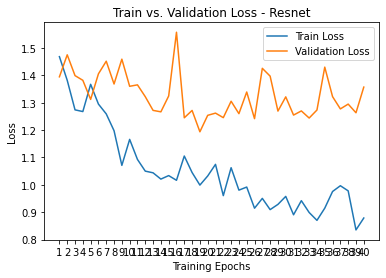

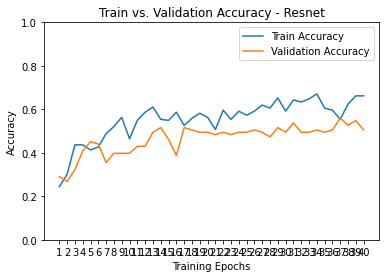

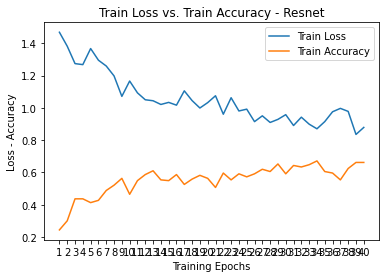

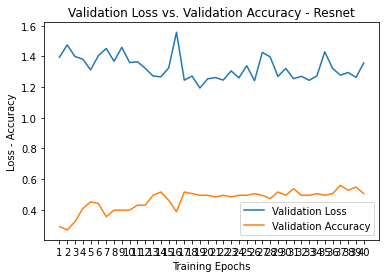

In [ ]:
if train_model:
    # train_loss_history_resnet, train_acc_history_resnet, val_loss_history_resnet, val_acc_history_resnet
    t_loss_resnet = [np.array(h) for h in train_loss_history_resnet]
    v_loss_resnet = [np.array(h) for h in val_loss_history_resnet]
    plt.title("Train vs. Validation Loss - Resnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_resnet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_resnet,label="Validation Loss")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_resnet = [h.cpu().numpy() for h in train_acc_history_resnet]
    v_acc_resnet = [h.cpu().numpy() for h in val_acc_history_resnet]
    plt.title("Train vs. Validation Accuracy - Resnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_resnet,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_resnet,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - Resnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_resnet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_resnet,label="Train Accuracy")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - Resnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_resnet,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_resnet,label="Validation Accuracy")
    # plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

In [ ]:
if train_model:
    # [resnet, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "alexnet"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft_alexnet, train_loss_history_alexnet, train_acc_history_alexnet, val_loss_history_alexnet, val_acc_history_alexnet = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/'
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_alexnet.state_dict(), os.path.join(path,'model_ft_alexnet.pt'))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/analytics/'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_alexnet), os.path.join(path,'train_loss_history_alexnet.pth'))
    torch.save(train_acc_history_alexnet, os.path.join(path,'train_acc_history_alexnet.pth'))
    torch.save(torch.tensor(val_loss_history_alexnet), os.path.join(path,'val_loss_history_alexnet.pth'))
    torch.save(val_acc_history_alexnet, os.path.join(path,'val_acc_history_alexnet.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

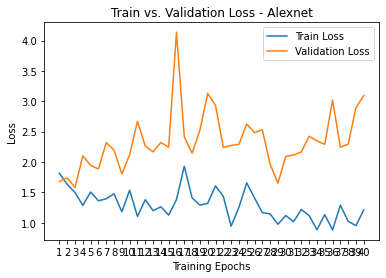

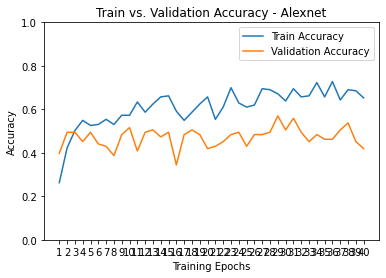

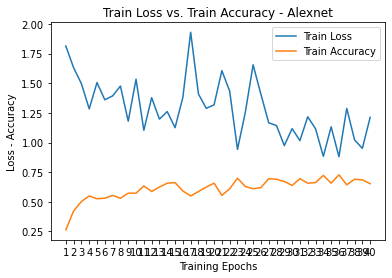

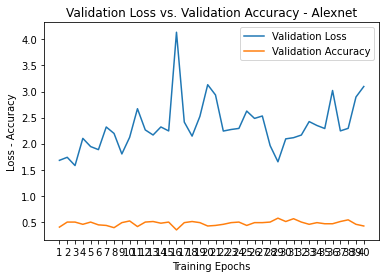

In [ ]:
if train_model:
    # train_loss_history_alexnet, train_acc_history_alexnet, val_loss_history_alexnet, val_acc_history_alexnet
    t_loss_alexnet = [np.array(h) for h in train_loss_history_alexnet]
    v_loss_alexnet = [np.array(h) for h in val_loss_history_alexnet]
    plt.title("Train vs. Validation Loss - Alexnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_alexnet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_alexnet,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_alexnet = [h.cpu().numpy() for h in train_acc_history_alexnet]
    v_acc_alexnet = [h.cpu().numpy() for h in val_acc_history_alexnet]
    plt.title("Train vs. Validation Accuracy - Alexnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_alexnet,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_alexnet,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - Alexnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_alexnet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_alexnet,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - Alexnet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_alexnet,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_alexnet,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

In [ ]:
if train_model:  
    # [resnet, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "vgg"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft_vgg, train_loss_history_vgg, train_acc_history_vgg, val_loss_history_vgg, val_acc_history_vgg = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/'
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_vgg.state_dict(), os.path.join(path,'model_ft_vgg.pt'))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/analytics/'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_vgg), os.path.join(path,'train_loss_history_vgg.pth'))
    torch.save(train_acc_history_vgg, os.path.join(path,'train_acc_history_vgg.pth'))
    torch.save(torch.tensor(val_loss_history_vgg), os.path.join(path,'val_loss_history_vgg.pth'))
    torch.save(val_acc_history_vgg, os.path.join(path,'val_acc_history_vgg.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

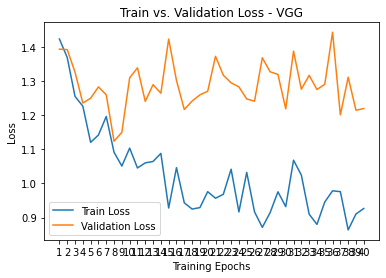

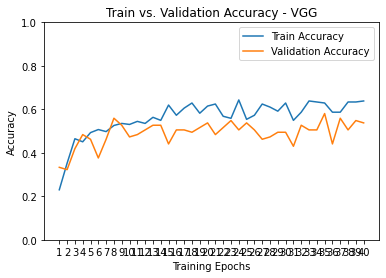

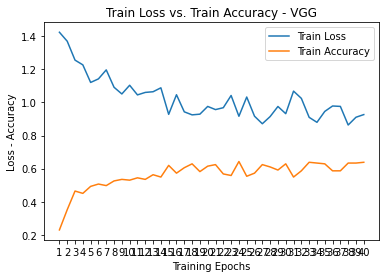

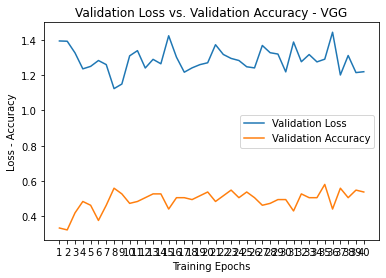

In [ ]:
if train_model:
    # train_loss_history_vgg, train_acc_history_vgg, val_loss_history_vgg, val_acc_history_vgg
    t_loss_vgg = [np.array(h) for h in train_loss_history_vgg]
    v_loss_vgg = [np.array(h) for h in val_loss_history_vgg]
    plt.title("Train vs. Validation Loss - VGG")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_vgg,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_vgg,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_vgg = [h.cpu().numpy() for h in train_acc_history_vgg]
    v_acc_vgg = [h.cpu().numpy() for h in val_acc_history_vgg]
    plt.title("Train vs. Validation Accuracy - VGG")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_vgg,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_vgg,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - VGG")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_vgg,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_vgg,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - VGG")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_vgg,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_vgg,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

In [ ]:
if train_model:
    # [resnet, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "squeezenet"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft_squeezenet, train_loss_history_squeezenet, train_acc_history_squeezenet, val_loss_history_squeezenet, val_acc_history_squeezenet = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/'
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_squeezenet.state_dict(), os.path.join(path,'model_ft_squeezenet.pt'))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/analytics/'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_squeezenet), os.path.join(path,'train_loss_history_squeezenet.pth'))
    torch.save(train_acc_history_squeezenet, os.path.join(path,'train_acc_history_squeezenet.pth'))
    torch.save(torch.tensor(val_loss_history_squeezenet), os.path.join(path,'val_loss_history_squeezenet.pth'))
    torch.save(val_acc_history_squeezenet, os.path.join(path,'val_acc_history_squeezenet.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

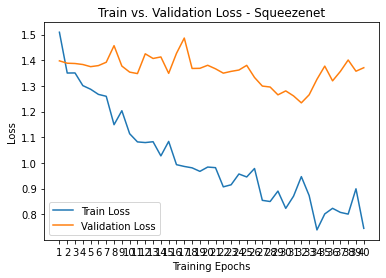

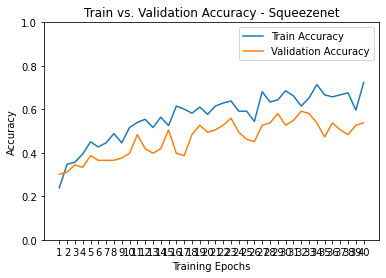

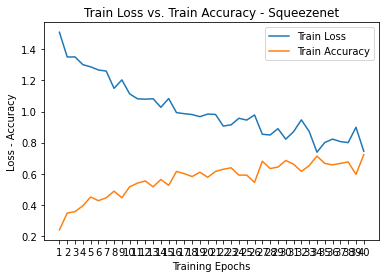

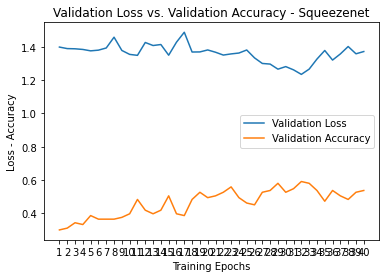

In [ ]:
if train_model:
    # train_loss_history_squeezenet, train_acc_history_squeezenet, val_loss_history_squeezenet, val_acc_history_squeezenet
    t_loss_squeezenet = [np.array(h) for h in train_loss_history_squeezenet]
    v_loss_squeezenet = [np.array(h) for h in val_loss_history_squeezenet]
    plt.title("Train vs. Validation Loss - Squeezenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_squeezenet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_squeezenet,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_squeezenet = [h.cpu().numpy() for h in train_acc_history_squeezenet]
    v_acc_squeezenet = [h.cpu().numpy() for h in val_acc_history_squeezenet]
    plt.title("Train vs. Validation Accuracy - Squeezenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_squeezenet,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_squeezenet,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - Squeezenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_squeezenet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_squeezenet,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - Squeezenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_squeezenet,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_squeezenet,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

In [8]:
 if train_model:
    # [resnet, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "densenet"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    # summary(model_ft, (3, input_size, input_size))

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft_densenet, train_loss_history_densenet, train_acc_history_densenet, val_loss_history_densenet, val_acc_history_densenet = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/'
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_densenet.state_dict(), os.path.join(path,'model_ft_densenet.pt'))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/analytics/'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_densenet), os.path.join(path,'train_loss_history_densenet.pth'))
    torch.save(train_acc_history_densenet, os.path.join(path,'train_acc_history_densenet.pth'))
    torch.save(torch.tensor(val_loss_history_densenet), os.path.join(path,'val_loss_history_densenet.pth'))
    torch.save(val_acc_history_densenet, os.path.join(path,'val_acc_history_densenet.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

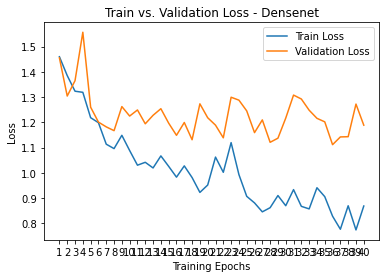

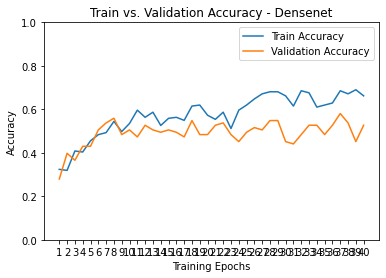

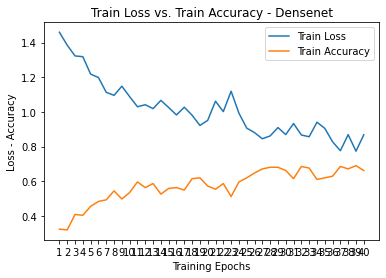

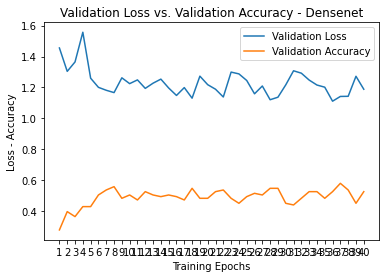

In [10]:
if train_model:
    # train_loss_history_densenet, train_acc_history_densenet, val_loss_history_densenet, val_acc_history_densenet
    t_loss_densenet = [np.array(h) for h in train_loss_history_densenet]
    v_loss_densenet = [np.array(h) for h in val_loss_history_densenet]
    plt.title("Train vs. Validation Loss - Densenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_densenet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_densenet,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_densenet = [h.cpu().numpy() for h in train_acc_history_densenet]
    v_acc_densenet = [h.cpu().numpy() for h in val_acc_history_densenet]
    plt.title("Train vs. Validation Accuracy - Densenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_densenet,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_densenet,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - Densenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_densenet,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_densenet,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - Densenet")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_densenet,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_densenet,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()

In [9]:
if train_model:
    # [resnet, alexnet, vgg, squeezenet, densenet, inception]
    model_name = "inception"
    feature_extract = True

    # Initialize the model for this run
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

    # Print the model we just instantiated
    print(model_ft)

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send the model to GPU
    model_ft = model_ft.to(device)
    summary(model_ft, (3, input_size, input_size))

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model_ft.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft_inception, train_loss_history_inception, train_acc_history_inception, val_loss_history_inception, val_acc_history_inception = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/'
    os.makedirs(path, exist_ok = True)
    torch.save(model_ft_inception.state_dict(), os.path.join(path,'model_ft_inception.pt'))
    path = '/content/drive/My Drive/Thesis/transfer_learning_model/feature_extraction/40/analytics/'
    os.makedirs(path, exist_ok = True)
    torch.save(torch.tensor(train_loss_history_inception), os.path.join(path,'train_loss_history_inception.pth'))
    torch.save(train_acc_history_inception, os.path.join(path,'train_acc_history_inception.pth'))
    torch.save(torch.tensor(val_loss_history_inception), os.path.join(path,'val_loss_history_inception.pth'))
    torch.save(val_acc_history_inception, os.path.join(path,'val_acc_history_inception.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

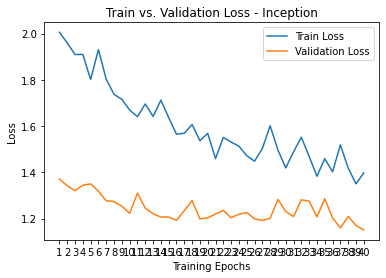

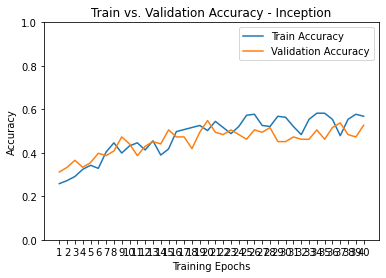

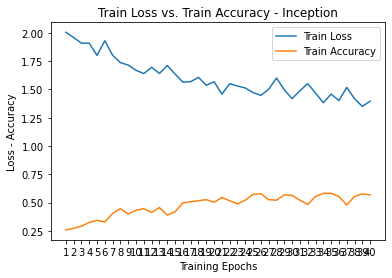

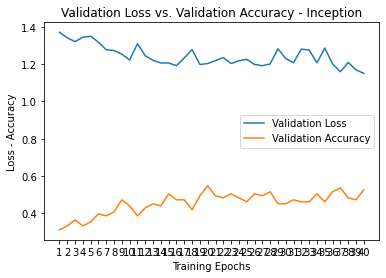

In [11]:
if train_model:
    # train_loss_history_inception, train_acc_history_inception, val_loss_history_inception, val_acc_history_inception
    t_loss_inception = [np.array(h) for h in train_loss_history_inception]
    v_loss_inception = [np.array(h) for h in val_loss_history_inception]
    plt.title("Train vs. Validation Loss - Inception")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1,num_epochs+1),t_loss_inception,label="Train Loss")
    plt.plot(range(1,num_epochs+1),v_loss_inception,label="Validation Loss")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    t_acc_inception = [h.cpu().numpy() for h in train_acc_history_inception]
    v_acc_inception = [h.cpu().numpy() for h in val_acc_history_inception]
    plt.title("Train vs. Validation Accuracy - Inception")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,num_epochs+1),t_acc_inception,label="Train Accuracy")
    plt.plot(range(1,num_epochs+1),v_acc_inception,label="Validation Accuracy")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Train Loss vs. Train Accuracy - Inception")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),t_loss_inception,label="Train Loss")
    plt.plot(range(1,num_epochs+1),t_acc_inception,label="Train Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()


    plt.title("Validation Loss vs. Validation Accuracy - Inception")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss - Accuracy")
    plt.plot(range(1,num_epochs+1),v_loss_inception,label="Validation Loss")
    plt.plot(range(1,num_epochs+1),v_acc_inception,label="Validation Accuracy")
    #plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.legend()
    plt.show()